In [122]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

In [123]:
from summer2 import CompartmentalModel
from summer2.parameters import Parameter

Building a simple SEIR model (based on https://www.frontiersin.org/articles/10.3389/fams.2023.1124897/full#T1)

In [124]:
def build_model():
    m = CompartmentalModel([0,100], ["S","E","I","R"],"I",ref_date=datetime(2023,1,1))
    m.set_initial_population({"S": 166198.0, "E": 16797.0, "I": 481.0, "R": 487.0})
    m.add_importation_flow("recruitment", num_imported=33595, dest="S", split_imports=True) #A
    m.add_universal_death_flows("universal_death", death_rate=0.143) #mu
    m.add_infection_density_flow("infection", Parameter("contact_rate"),"S","E") #alpha I
    m.add_transition_flow("partial_vax", 0.2522,"S","E") #V_p
    m.add_transition_flow("full_vax", 0.1517,"S","R") #V_f
    m.add_transition_flow("progression", Parameter("progression"),"E","I") #delta
    m.add_transition_flow("recovery", 0.09,"I","R") #gamma
    m.add_death_flow("disease_death", 0.1595,"I") #mu_1
    m.request_output_for_flow("infection", "infection")
    m.request_output_for_flow("recovery", "recovery")
    m.request_output_for_flow(
        "progressions",
        "progression"
    )
    return m

In [125]:
m = build_model()

In [126]:
m.get_input_parameters()

{'contact_rate', 'progression'}

In [127]:
parameters = {"contact_rate": 0.00001, "progression": 1.01}

In [128]:
m.run(parameters)

<Axes: >

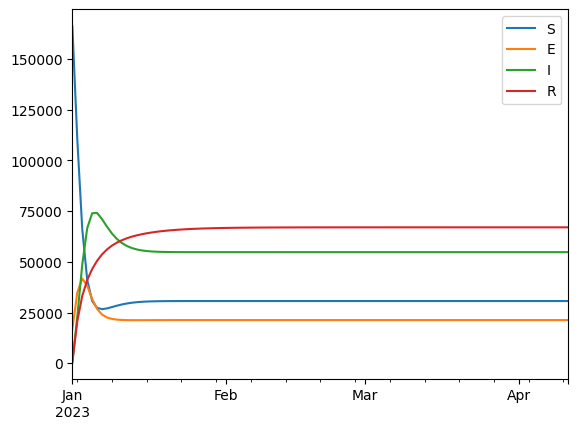

In [129]:
m.get_outputs_df().plot()

<Axes: >

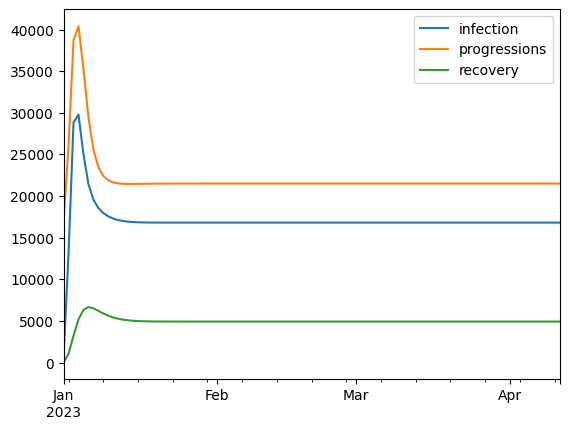

In [130]:
m.get_derived_outputs_df().plot()

In [131]:
ndata = m.get_derived_outputs_df()["infection"]
ndata = ndata[:30]

<Axes: >

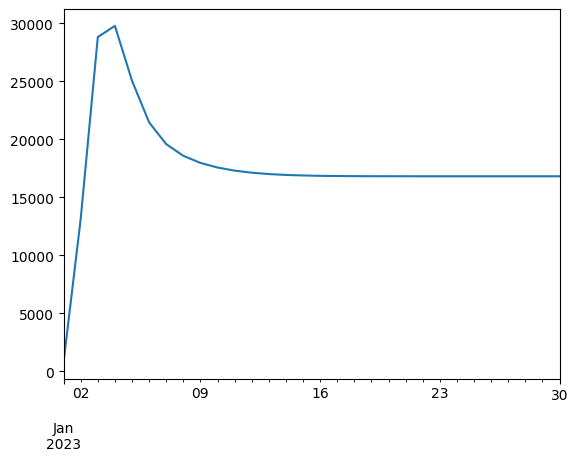

In [132]:
ndata.plot()

Calibration

In [133]:
# Targets represent data we are trying to fit to
from estival import targets as est

# We specify parameters using (Bayesian) priors
from estival import priors as esp

# Finally we combine these with our summer2 model in a BayesianCompartmentalModel (BCM)
from estival.model import BayesianCompartmentalModel

In [134]:
targets = [
    est.NormalTarget("infection", ndata, np.std(ndata) * 0.1)
]

In [135]:
priors = [
    esp.UniformPrior("contact_rate", (0.0,0.5)),
    esp.UniformPrior("progression", (0.5,1.5))
]

In [136]:
defp = {"contact_rate": 0.000015, "progression": 0.95}

In [137]:
bcm = BayesianCompartmentalModel(m, defp, priors, targets)
from estival.wrappers import pymc as epm
import pymc as pm

In [138]:
with pm.Model() as model:

    # This is all you need - a single call to use_model
    variables = epm.use_model(bcm)

    # The log-posterior value can also be output, but may incur additional overhead
    # Use jacobian=False to get the unwarped value (ie just the 'native' density of the priors
    # without transformation correction factors)
    # pm.Deterministic("logp", model.logp(jacobian=False))

    # Now call a sampler using the variables from use_model
    # In this case we use the Differential Evolution Metropolis sampler
    # See the PyMC docs for more details
    idata = pm.sample(step=[pm.DEMetropolis(variables)], draws=4000, tune=0,cores=4,chains=4)

Population sampling (4 chains)
DEMetropolis: [contact_rate, progression]
Attempting to parallelize chains to all cores. You can turn this off with `pm.sample(cores=1)`.


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


/Users/mark/miniconda3/envs/summer2/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:844: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/mark/miniconda3/envs/summer2/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:844: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/mark/miniconda3/envs/summer2/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:844: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/mark/miniconda3/envs/summer2/lib/python3.10/site-packages/pymc/step_methods/metropolis.py:844: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 4 chains for 0 tune and 4_000 draw iterations (0 + 16_000 draws total) took 34 seconds.


Visualizing Outputs

In [139]:
import arviz as az

In [140]:
az.summary(idata)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
contact_rate,0.001,0.016,0.000,0.0,0.001,0.000,950.0,780.0,1.01
progression,1.051,0.205,0.759,1.5,0.008,0.006,618.0,411.0,1.01


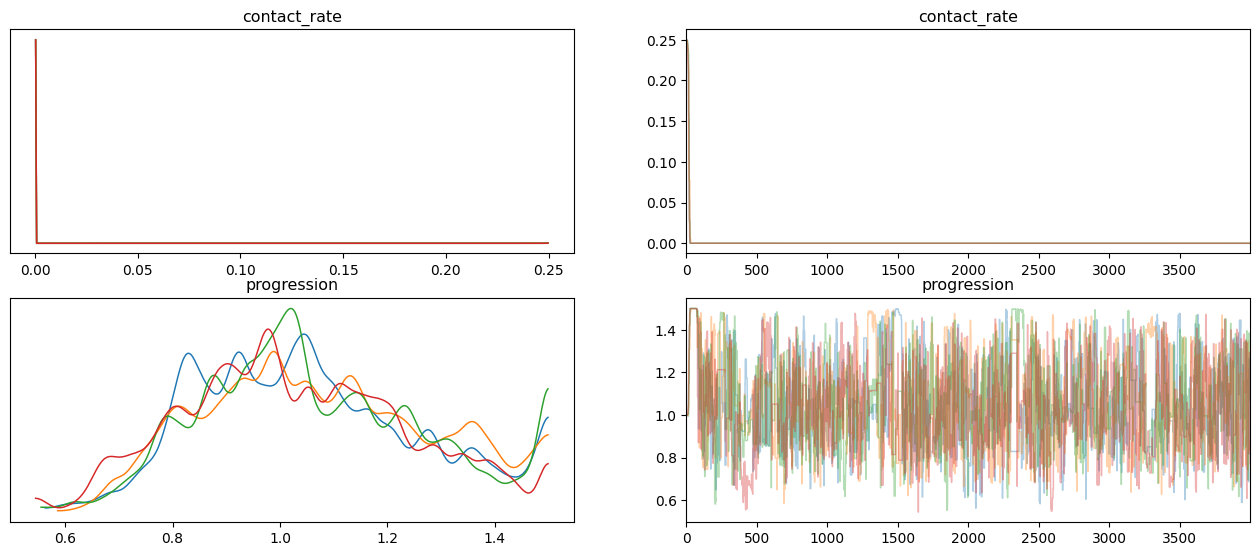

In [141]:
az.plot_trace(idata, figsize=(16,3.2*len(idata.posterior)),compact=False);#, lines=[("m", {}, mtrue), ("c", {}, ctrue)]);

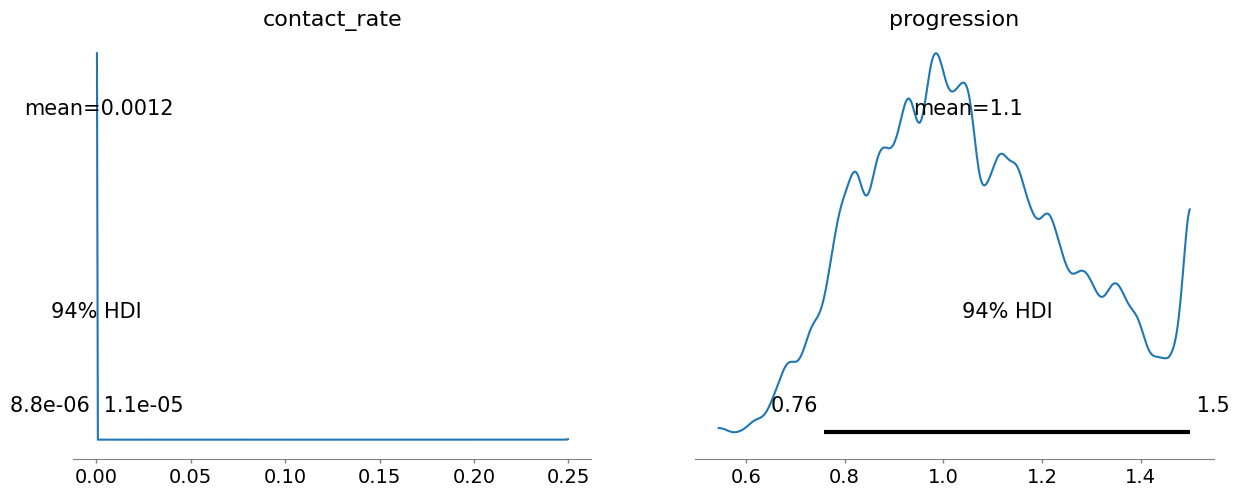

In [142]:
az.plot_posterior(idata);

In [ ]:
Obtaining Likelihood

In [143]:
from estival.sampling.tools import likelihood_extras_for_idata

In [144]:
likelihood_df = likelihood_extras_for_idata(idata, bcm)

<Axes: xlabel='draw'>

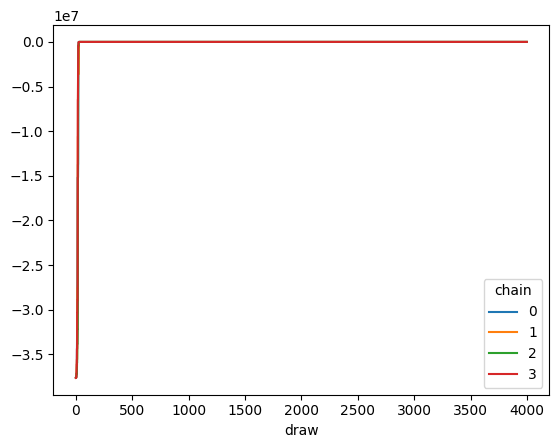

In [145]:
ldf_pivot = likelihood_df.reset_index(level="chain").pivot(columns=["chain"])

ldf_pivot["logposterior"].plot()

In [146]:
# Sort this DataFrame by logposterior to obtain the MAP index
ldf_sorted = likelihood_df.sort_values(by="logposterior",ascending=False)

# Extract the parameters from the calibration samples
map_params = idata.posterior.to_dataframe().loc[ldf_sorted.index[0]].to_dict()

map_params

{'contact_rate': 1.0003669803310376e-05, 'progression': 1.0099002997598985}

In [147]:
bcm.loglikelihood(**map_params), ldf_sorted.iloc[0]["loglikelihood"]

(Array(-7.07195593, dtype=float64), -7.071955932661735)

In [148]:
map_res = bcm.run(map_params)

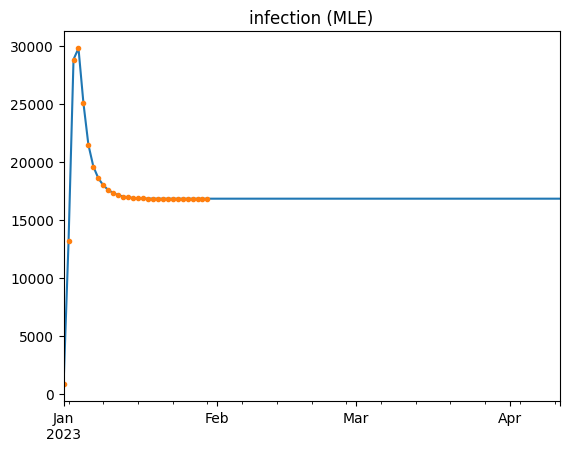

In [149]:
variable = "infection"

pd.Series(map_res.derived_outputs[variable]).plot(title = f"{variable} (MLE)")
bcm.targets[variable].data.plot(style='.');

Uncertainty sampling

In [150]:
sample_idata = az.extract(idata, num_samples = 400)
samples_df = sample_idata.to_dataframe().drop(columns=["chain","draw"])

In [151]:
from estival.utils.parallel import map_parallel

In [152]:
def run_sample(idx_sample):
    idx, params = idx_sample
    return idx, bcm.run(params)

In [153]:
sample_res = map_parallel(run_sample, samples_df.iterrows(), n_workers=4)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [154]:
import xarray as xr

In [155]:
xres = xr.DataArray(np.stack([r.derived_outputs for idx, r in sample_res]),
                    dims=["sample","time","variable"])
xres = xres.assign_coords(sample=sample_idata.coords["sample"],
                          time=map_res.derived_outputs.index, variable=map_res.derived_outputs.columns)

In [156]:
# Set some quantiles to calculate
quantiles = (0.01,0.05,0.25,0.5,0.75,0.95,0.99)

# Generate a new DataArray containing the quantiles
xquantiles = xres.quantile(quantiles,dim=["sample"])

In [157]:
# Extract these values to a pandas DataFrame for ease of plotting

uncertainty_df = xquantiles.to_dataframe(name="value").reset_index().set_index("time").pivot(columns=("variable","quantile"))["value"]

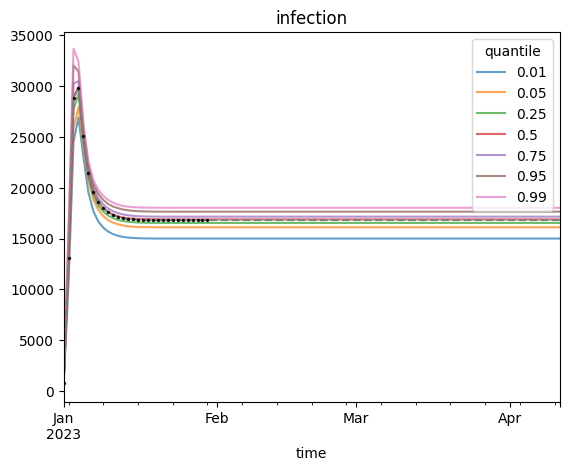

In [158]:
variable = "infection"

fig = uncertainty_df[variable].plot(title=variable,alpha=0.7)
pd.Series(map_res.derived_outputs[variable]).plot(style='--')
bcm.targets[variable].data.plot(style='.',color="black", ms=3, alpha=0.8);